In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load Titanic Data

In [238]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv("titanic_test.csv")
IDtest = test["PassengerId"]
train_len = len(train)
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

Data Preprocessing

In [239]:
def determine_age(cols):
    age = cols[0]
    pclass = cols[1]
    if np.isnan(age):
        if(pclass == 1):
            return 37
        elif(pclass==2):
            return 29
        else:
            return 24
    else:
        return age
    
df['Age'] = df[['Age','Pclass']].apply(determine_age,axis=1)

Get Cabin Initials as a new feature

In [240]:
def cabinletter (cabin):
    if pd.isnull(cabin):
        return 'U'
    else:
        return cabin[0]
    
##To Avoid Overfitting
df['CabinInit'] = df['Cabin'].apply(cabinletter)

Get Title and Name length as 2 new feature

In [241]:
df['Title']= df['Name'].apply(lambda name:name.split('.')[0].split(',')[1].strip())

In [242]:
df['NameLength'] = df['Name'].apply(lambda name:len(name.strip()))

In [243]:
df['Ticket_Lett'] = df['Ticket'].apply(lambda x: str(x)[0])
df['Ticket_Lett'] = df['Ticket_Lett'].apply(lambda x: str(x))
df['Ticket_Lett'] = np.where((df['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), df['Ticket_Lett'],
                                  np.where((df['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))

In [244]:
def standardize_title(title):
    if title.lower() in ['mr','miss','mrs','master']:
        return title
    elif title.lower() in ['ms','mlle']:
        return 'Miss'
    elif title.lower() in ['mme']:
        return 'Mrs'
    else:
        return 'Rare'
df['Title'] = df['Title'].apply(standardize_title)

In [245]:
df['FamilySize'] = df[['Parch','SibSp']].apply(lambda cols:cols[0]+cols[1] +1,axis=1)

In [246]:
def normalizefare(cols):
    Ticket = cols[0]
    Fare = cols[1]
    pplinsameticket = len(df[df['Ticket'] == Ticket])   
    if(pplinsameticket > 1):
        Fare = Fare/pplinsameticket
    return Fare

In [247]:
 df['Fare'] = df[['Ticket','Fare']].apply(normalizefare,axis=1)

In [248]:
def FareCategory(Fare):
    if Fare >60:
        return 'High'
    elif Fare <= 60 and Fare >40:
        return 'Medium'
    else:
        return 'Low'

In [249]:
#df['FareCategory'] = df['Fare'].apply(FareCategory)

In [250]:
def GroupSurvival(ticket):
    GroupSurvival = 0
    if len(df[df['Ticket'] == ticket]) > 3:
        SurvivedInTicket = len(df[(df['Ticket'] == ticket) & (df['Survived'] == 1)])
        DeadInTicket = len(df[(df['Ticket'] == ticket) & (df['Survived'] == 0)])
        if(SurvivedInTicket+DeadInTicket > 2):
            GroupSurvival = SurvivedInTicket/(SurvivedInTicket + DeadInTicket)
    if GroupSurvival < 0.4:
        return 'low'
    if (GroupSurvival >= 0.4) & (GroupSurvival <= 0.6):
        return 'Medium'
    else:
        return 'High'


def TravelInGroup(ticket):
    if len(df[df['Ticket'] == ticket]) > 3:
        return 1.0
    else:
        return 0.0

In [251]:
df['PartofGroup'] = df['Ticket'].apply(TravelInGroup)

In [252]:
df['GroupSurvival'] = df['Ticket'].apply(GroupSurvival)

In [253]:
df.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,CabinInit,Title,NameLength,Ticket_Lett,FamilySize,PartofGroup,GroupSurvival
0,22.0,NaN,S,7.25000,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,U,Mr,23,A,2,0.0,low
1,38.0,C85,C,35.64165,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,C,Mrs,51,P,2,0.0,low


In [254]:
df['Fare'].fillna(0,inplace=True)

In [255]:
df['Embarked'].fillna('S',inplace=True)

In [256]:
df['FareBin'] = pd.qcut(df['Fare'], 4)

In [257]:
df['AgeBin'] = pd.cut(df['Age'].astype(int), 5)

In [258]:
df.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket,CabinInit,Title,NameLength,Ticket_Lett,FamilySize,PartofGroup,GroupSurvival,FareBin,AgeBin
0,22.0,NaN,S,7.25000,"Braund, Mr. Owen Harris",0,1,3,male,1,...,A/5 21171,U,Mr,23,A,2,0.0,low,"(-0.001, 7.55]","(16.0, 32.0]"
1,38.0,C85,C,35.64165,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,PC 17599,C,Mrs,51,P,2,0.0,low,"(15.0, 128.082]","(32.0, 48.0]"


In [259]:
df_dummies = pd.get_dummies(df[['Embarked','Title','Sex','CabinInit','AgeBin','FareBin', 'GroupSurvival','Ticket_Lett']],drop_first=True) #,'CabinInit','FareCategory','AgeBin','FareBin'
df = pd.concat([df,df_dummies], axis=1)
df.drop(labels = ['Embarked','Title','Sex','FareBin','AgeBin','CabinInit','GroupSurvival','Ticket_Lett'],axis=1, inplace=True) #,'CabinInit','FareCategory'

In [260]:
df.drop(labels = ['Name','Ticket','Cabin'],axis=1, inplace=True )

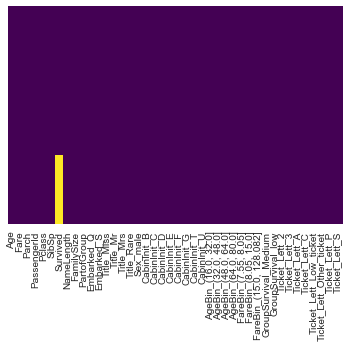

In [261]:
sns.heatmap(df.isnull(),annot=False, yticklabels=False,cbar=False,cmap='viridis')

In [262]:
df.head(2)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,NameLength,FamilySize,PartofGroup,...,GroupSurvival_Medium,GroupSurvival_low,Ticket_Lett_2,Ticket_Lett_3,Ticket_Lett_A,Ticket_Lett_C,Ticket_Lett_Low_ticket,Ticket_Lett_Other_ticket,Ticket_Lett_P,Ticket_Lett_S
0,22.0,7.25000,0,1,3,1,0.0,23,2,0.0,...,0,1,0,0,1,0,0,0,0,0
1,38.0,35.64165,0,2,1,1,1.0,51,2,0.0,...,0,1,0,0,0,0,0,0,1,0


In [263]:
train = df[:train_len]
test = pd.DataFrame.copy(df[train_len:], deep=True)

In [264]:
test.drop('PassengerId', axis=1, inplace =True)
test.drop('Survived', axis=1, inplace =True)

In [265]:
X = train.drop(labels= ['PassengerId','Survived'],axis=1)
y = train['Survived']

Check for Outlier

In [266]:
# 1st quartile (25%)
Q1 = np.percentile(df['Age'], 25)
# 3rd quartile (75%)
Q3 = np.percentile(df['Age'],75)
# Interquartile range (IQR)
IQR = Q3 - Q1
# outlier step
outlier_step = 1.5 * IQR

# Determine a list of indices of outliers for feature col
outlier_list_col = df[(df['Age'] < Q1 - outlier_step) | (df['Age'] > Q3 + outlier_step )].index

# There are outlier problem in titanic to deal , the above code is for reference

Modelling with common algorithms

In [267]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [268]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification,confusion_matrix

Try Stratified K Fold Cross validation 

In [269]:
kfold = StratifiedKFold(n_splits = 10,shuffle=False)

In [270]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 40 columns):
Age                         891 non-null float64
Fare                        891 non-null float64
Parch                       891 non-null int64
Pclass                      891 non-null int64
SibSp                       891 non-null int64
NameLength                  891 non-null int64
FamilySize                  891 non-null int64
PartofGroup                 891 non-null float64
Embarked_Q                  891 non-null uint8
Embarked_S                  891 non-null uint8
Title_Miss                  891 non-null uint8
Title_Mr                    891 non-null uint8
Title_Mrs                   891 non-null uint8
Title_Rare                  891 non-null uint8
Sex_male                    891 non-null uint8
CabinInit_B                 891 non-null uint8
CabinInit_C                 891 non-null uint8
CabinInit_D                 891 non-null uint8
CabinInit_E                 891 non-null ui

In [271]:
lrm = LogisticRegression(random_state=12)
lrm_param_grid = {"C":[1,100,1000],
                 }
lrmGS = GridSearchCV(lrm,param_grid = lrm_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
lrmGS.fit(X,y)
lrm_best = lrmGS.best_estimator_

lrmGS.best_score_

#CV_Result = cross_val_score(lrm,X,y, scoring='accuracy',cv=kfold)
#print(CV_Result.mean())
#print(CV_Result.std())

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   59.2s finished


0.83389450056116721

In [272]:
lrm_best

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [273]:
lrm_best

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [274]:
lrm_best

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [275]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.model_selection import ShuffleSplit,cross_validate


In [276]:
#Machine Learning Algorithm (MLA) Selection and initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_estimators = 20),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model. RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(n_neighbors = 3),
    
    #SVM
    svm.SVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy Min' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)




D:\MachineLearn\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\MachineLearn\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\MachineLearn\Anaco

In [277]:
#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_compare.loc[row_index, 'MLA Name'] = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = cross_validate(alg, X, y, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test Accuracy Min'] = cv_results['test_score'].min()   #let's know the worst that can happen!

    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
#print(MLA_compare)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy Min,MLA Time
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.847191,0.827985,0.813433,0.0125
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.991948,0.827612,0.809701,0.0732741
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.931835,0.826866,0.802239,0.209615
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.850187,0.820896,0.798507,1.179
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.998127,0.813806,0.783582,0.0305054
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.979588,0.812687,0.776119,0.0421893
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.867978,0.802985,0.753731,0.153693
14,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.826217,0.8,0.735075,0.0843786
15,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.998127,0.783955,0.75,0.0078124
16,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.998127,0.763806,0.708955,0.00312557


In [278]:
# RFC Parameters tunning 
RFC = RandomForestClassifier(random_state=12)

## Search grid for optimal parameters
rf_param_grid = {
              #"max_depth": [None],
              #"max_features": [None,'sqrt','log2'],
              "min_samples_split": [2,5,6],
              "min_samples_leaf": [8,10,12],
              "bootstrap": [False],
              "n_estimators" :[10,20,50,100,200],
              "criterion": ['gini','entropy']
             }

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X,y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_


Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 900 out of 900 | elapsed:  3.9min finished


0.83726150392817056

In [279]:
RFC_best

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)

In [280]:
RFC_best

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)

In [281]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = RFC_best.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

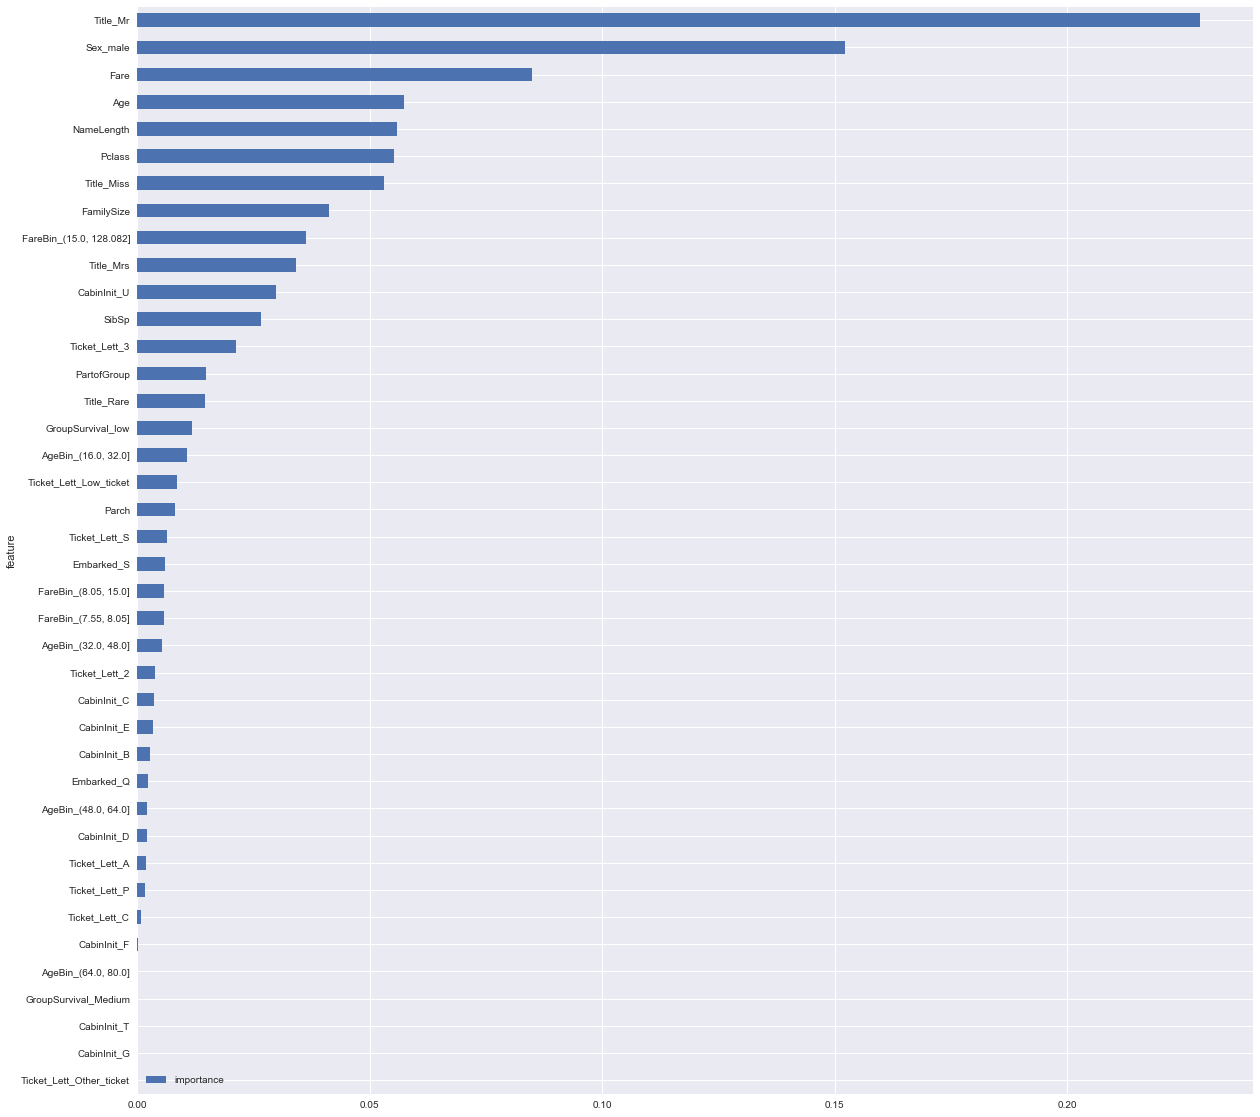

In [282]:
features.plot(kind='barh', figsize=(20, 20))

In [283]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(RFC_best, prefit=True)
train_reduced = model.transform(X)
train_reduced.shape

test_reduced = model.transform(test)
test_reduced.shape
#RFC_best = RandomForestClassifier(n_estimators=100, min_samples_leaf=10,min_samples_split=10,max_features=3, oob_score=True)

(418, 12)

DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X,y)
ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

In [284]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X,y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  2.9min finished


0.82379349046015715

In [285]:
#GBC_best = GradientBoostingClassifier(n_estimators=200,learning_rate=0.1,max_depth=4,min_samples_leaf=100,max_features=0.3)

### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [50,100,200,300]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X,y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

In [286]:
SVMC_best

NameError: name 'SVMC_best' is not defined

In [ ]:
#SVMC_best = SVC(probability=True, gamma=0.001,C=1000)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#g = plot_learning_curve(gsSVMC.best_estimator_,"SVM learning curves",X,y,cv=kfold)

In [ ]:
#g = plot_learning_curve(gsGBC.best_estimator_,"GB learning curves",X,y,cv=kfold)
RFC_best

Ensembling more than one model

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('lrm', lrm_best),
('GBC', GBC_best)], voting='soft', n_jobs=4)

#votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('lrm', lrm_best),
#('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X, y)

In [ ]:
pred = pd.Series(votingC.predict(test), name='Survived')

In [ ]:
output = pd.concat([IDtest,pred.astype(int)], axis=1)

In [235]:
output.to_csv("Titanic_Viswa15.csv",index=False)

In [236]:
df[df['PassengerId'].apply(lambda id: True if id in(924,925,893,1231,1236,1251)else False)]

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,NameLength,FamilySize,PartofGroup,...,GroupSurvival_Medium,GroupSurvival_low,Ticket_Lett_2,Ticket_Lett_3,Ticket_Lett_A,Ticket_Lett_C,Ticket_Lett_Low_ticket,Ticket_Lett_Other_ticket,Ticket_Lett_P,Ticket_Lett_S
892,47.0,7.000000,0,893,3,1,NaN,32,2,0.0,...,0,1,0,1,0,0,0,0,0,0
923,33.0,5.143750,2,924,3,1,NaN,40,4,1.0,...,0,1,0,0,0,1,0,0,0,0
924,24.0,5.862500,2,925,3,1,NaN,49,4,1.0,...,0,1,0,0,0,0,1,0,0,0
1230,24.0,7.229200,0,1231,3,0,NaN,21,1,0.0,...,0,1,1,0,0,0,0,0,0,0
1235,24.0,4.833333,1,1236,3,1,NaN,35,3,0.0,...,0,1,0,0,1,0,0,0,0,0
1250,30.0,7.775000,0,1251,3,1,NaN,51,2,0.0,...,0,1,0,1,0,0,0,0,0,0
